In [53]:
import pandas as pd
import numpy as np
import os
import threading
import sys
import time
from datetime import datetime
from matplotlib import pyplot as plt
import random
import copy

In [54]:
f_ =  "merged_providerRPC_MCR.csv"
df = pd.read_csv(f_)
df

,Unnamed: 0,msname,timestamp,num,sum,avg,std,min,max,p0.1,p1,p5,p10,p25,p50,p75,p90,p95,p99,p99.9
0,11310,002251d4123496684687c2acad43bdef9419a5e4fc01a6...,0,437,18437.866667,42.191915,2.168923,0.000000,45.116667,17.461800,40.346667,40.980000,41.300000,41.766667,42.233333,42.816667,43.323333,43.573333,44.094000,44.869600
1,11311,002251d4123496684687c2acad43bdef9419a5e4fc01a6...,60000,437,18787.083333,42.991037,2.232557,0.000000,46.316667,17.476333,41.056000,41.746667,42.020000,42.500000,43.050000,43.650000,44.183333,44.590000,45.232000,46.135000
2,11312,002251d4123496684687c2acad43bdef9419a5e4fc01a6...,120000,437,18893.150000,43.233753,2.244835,0.000000,45.716667,17.926867,41.356000,41.946667,42.243333,42.700000,43.333333,43.916667,44.466667,44.826667,45.166667,45.709400
3,11313,002251d4123496684687c2acad43bdef9419a5e4fc01a6...,180000,437,18877.183333,43.197216,2.225311,0.000000,45.716667,17.919600,41.462000,41.883333,42.266667,42.700000,43.300000,43.866667,44.283333,44.623333,45.316667,45.665800
4,11314,002251d4123496684687c2acad43bdef9419a5e4fc01a6...,240000,437,18976.150000,43.423684,2.223884,0.000000,45.450000,17.977733,41.595333,42.230000,42.483333,42.983333,43.533333,44.100000,44.516667,44.750000,45.404667,45.442733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874962,20300,ffe2951a804109b8d947cf3d26a391d389d537af135a93...,42960000,10,921.350000,92.135000,1.033990,90.783333,94.166667,90.783483,90.784833,90.790833,90.798333,91.345833,92.108333,92.712500,93.311667,93.739167,94.081167,94.158117
874963,20310,ffe2951a804109b8d947cf3d26a391d389d537af135a93...,43020000,10,1014.066667,101.406667,1.362477,98.966667,102.833333,98.974617,99.046167,99.364167,99.761667,100.150000,101.916667,102.600000,102.818333,102.825833,102.831833,102.833183
874964,20320,ffe2951a804109b8d947cf3d26a391d389d537af135a93...,43080000,10,959.333333,95.933333,0.760847,94.583333,97.350000,94.587533,94.625333,94.793333,95.003333,95.508333,95.866667,96.462500,96.645000,96.997500,97.279500,97.342950
874965,20330,ffe2951a804109b8d947cf3d26a391d389d537af135a93...,43140000,10,923.200000,92.320000,1.475029,90.333333,94.833333,90.336333,90.363333,90.483333,90.633333,91.062500,92.008333,93.362500,94.278333,94.555833,94.777833,94.827783


In [55]:
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
print(df.shape[0])
df = df[df["avg"]>1]
df = df[df["num"] > 1]
df = df.sort_values(by=["std"], ascending=False)
std_sorted_ms = list(df["msname"].unique())
# 4s

874967


In [56]:
p99 = df["p99"].to_list()
p1 = df["p1"].to_list()
diff_p99_p1 = list()
for i in range(len(p99)):
    diff_p99_p1.append(p99[i] - p1[i])
df["p99-p1"] = diff_p99_p1

p99 = df["p99"].to_list()
p50 = df["p50"].to_list()
diff_p99_p50 = list()
for i in range(len(p99)):
    diff_p99_p50.append(p99[i] - p50[i])
df["p99-p50"] = diff_p99_p50
df = df.reset_index(drop=True)

p99p50_sort_df = df.sort_values(by=["p99-p50"], ascending=False)
p99p50_sort_df = p99p50_sort_df.reset_index(drop=True)
p99p50_sort_ms = list(p99p50_sort_df["msname"].unique())

original_ms_list = list(df["msname"].unique())

In [57]:
idx = 0
mcr_map = dict()
for ms in original_ms_list:
    if idx == 1:
        break
    temp_df = df[df["msname"] == ms]
    temp_df = temp_df.sort_values(by=["timestamp"])
    mcr = temp_df["sum"].to_list()
    mcr_map[ms] = mcr
    
# 35s

In [58]:
def detect_microburst(call_rate, window_size, burst_degree):
    burst_ts = list()
    burst_cnt = 0
    burst_detect = 0
    for i in range(window_size, len(call_rate)):
        if burst_detect == 0:
            prev_window_avg = sum(call_rate[i-window_size:i])/window_size
            if call_rate[i] > prev_window_avg * burst_degree:
                burst_cnt += 1
                burst_ts.append(i)
                burst_detect = window_size
        else:
            burst_detect -= 1
    return burst_cnt, burst_ts

In [59]:
sort_by_burstness = list()

ts = time.time()
idx = 0
window_size=5
burst_degree=2
for msname in mcr_map:
    burst_cnt, burst_timestamp = detect_microburst(mcr_map[msname], window_size, burst_degree)
    sort_by_burstness.append([msname, burst_cnt, mcr_map[msname], burst_timestamp])
    # print("index: {}, msname: {}, burst_cnt: {}".format(idx, msname, burst_cnt))
    # if idx == 0:
    #     break
    idx += 1
print("detect_microburst: {} sec".format(time.time() - ts))
    
ts = time.time()
sort_by_burstness.sort(key=lambda x:x[1], reverse=True)
print("sorting: {} sec".format(time.time() - ts))

detect_microburst: 0.36578989028930664 sec
sorting: 0.0002689361572265625 sec


In [69]:
''' burst statistics '''
burst_cnt_list = [ x[1] for x in sort_by_burstness]
burst_service = [ x for x in sort_by_burstness if x[1] > 0]
print("total num burst: {}".format(sum(burst_cnt_list)))
avg_per_service = sum(burst_cnt_list)/len(burst_cnt_list)

print("len(burst_cnt_list): ", len(burst_cnt_list))
print("len(burst_service): ", len(burst_service))
print("sum(burst_cnt_list): ", sum(burst_cnt_list))
print("max(burst_cnt_list): ", max(burst_cnt_list))
print("avg(burst): ", sum(burst_cnt_list)/len(burst_cnt_list))
print("avg(burst): ", sum(burst_cnt_list)/len(burst_service))
print("min(burst_cnt_list): ", min(burst_cnt_list))

print("average num of burst per service during 12 hours: {}".format(avg_per_service))
print("average num of burst per service per hour: {}".format(avg_per_service/12))
print("num service having at least one burst: {}".format(len(burst_service)))


total num burst: 2703
len(burst_cnt_list):  1031
len(burst_service):  264
sum(burst_cnt_list):  2703
max(burst_cnt_list):  72
avg(burst):  2.6217264791464596
avg(burst):  10.238636363636363
min(burst_cnt_list):  0
average num of burst per service during 12 hours: 2.6217264791464596
average num of burst per service per hour: 0.2184772065955383
num service having at least one burst: 264


In [10]:
shuffled_call_rate = copy.deepcopy(sort_by_burstness)
random.seed(1234)
random.shuffle(shuffled_call_rate)

num burst: 6, ms: 17416a2a9867a0074d398bb5ff053545853473911a736fa9c5058a68e6e13e51


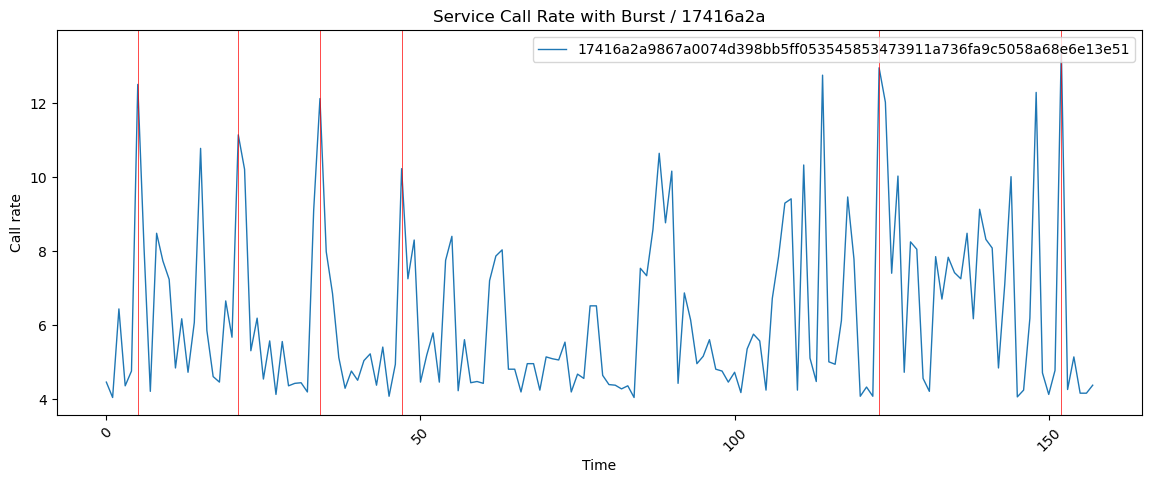

num burst: 5, ms: 782f494164510bd6d5eb4062bda9ea0f6afdc35100c16b75123bfe4c9030a730


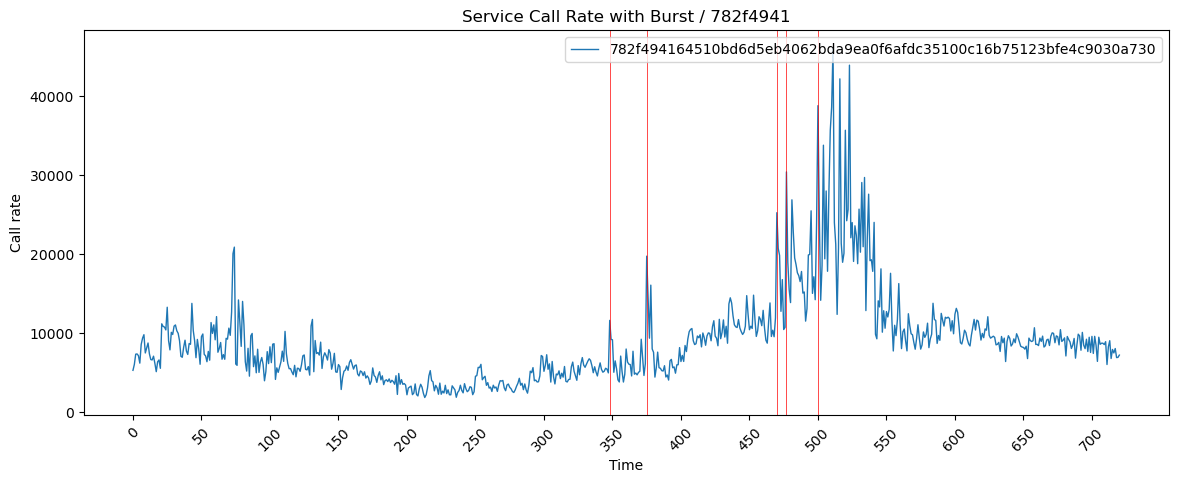

num burst: 5, ms: bce1ca5c2a081c9a114ac07847bccd32e94596d0433509704a4aaf57b96faa0c


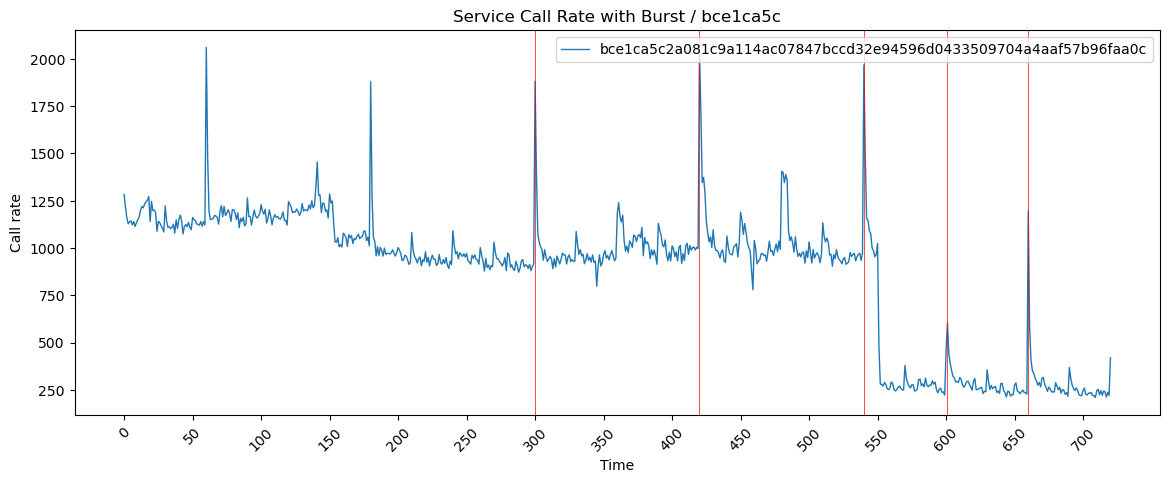

num burst: 5, ms: 5c32feba893b831a22b2cacf9e101d4b17068bfe3ae3d122a9cba88ec6007f6d


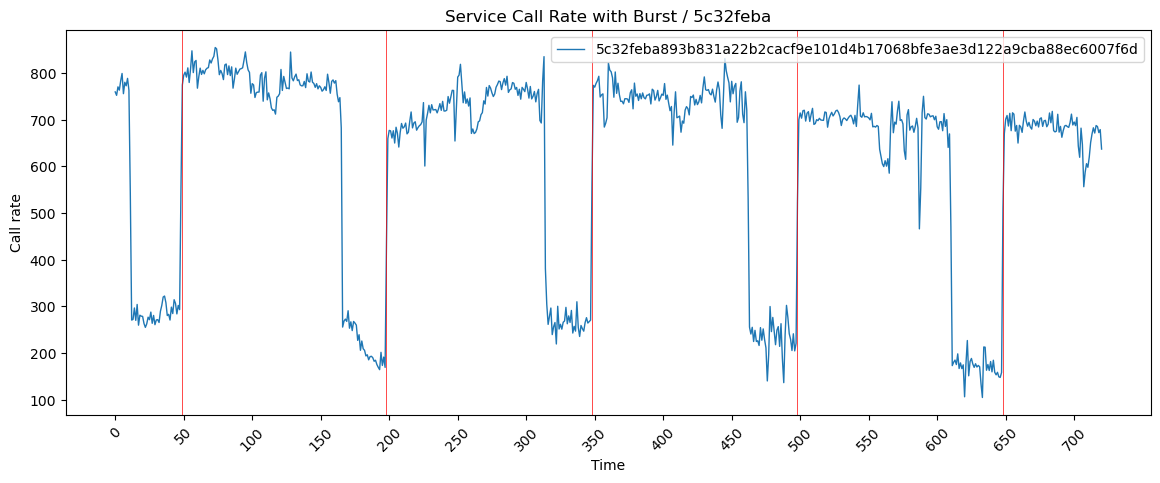

num burst: 5, ms: 1763f9bab0449b3fe77d546645ecb1b18b92ba039c6405c7c375158d01b9b44a


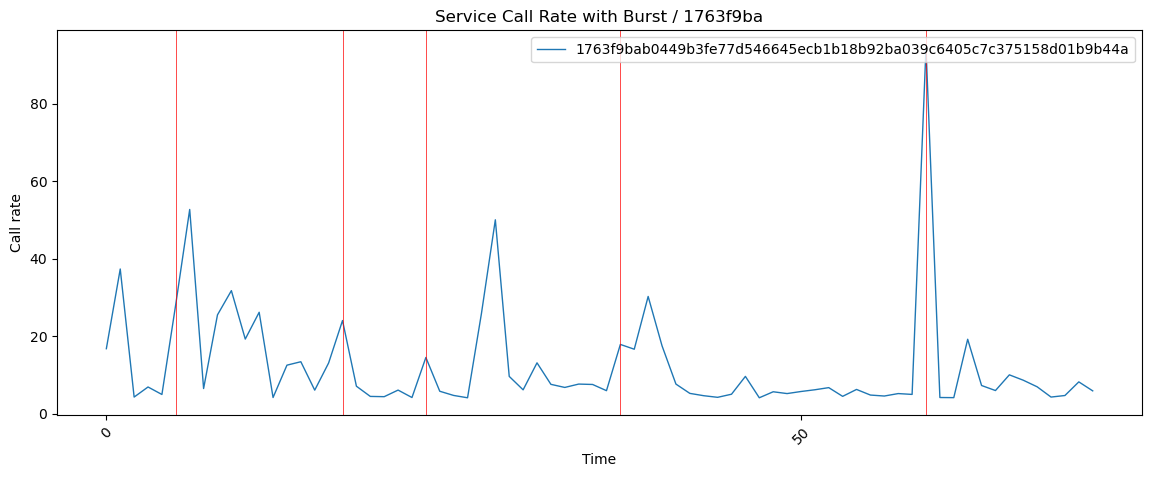

num burst: 5, ms: 868136ef25a3092bba5bc4fbdd98a10e4624cec018c9c1529eedb3c01414da5a


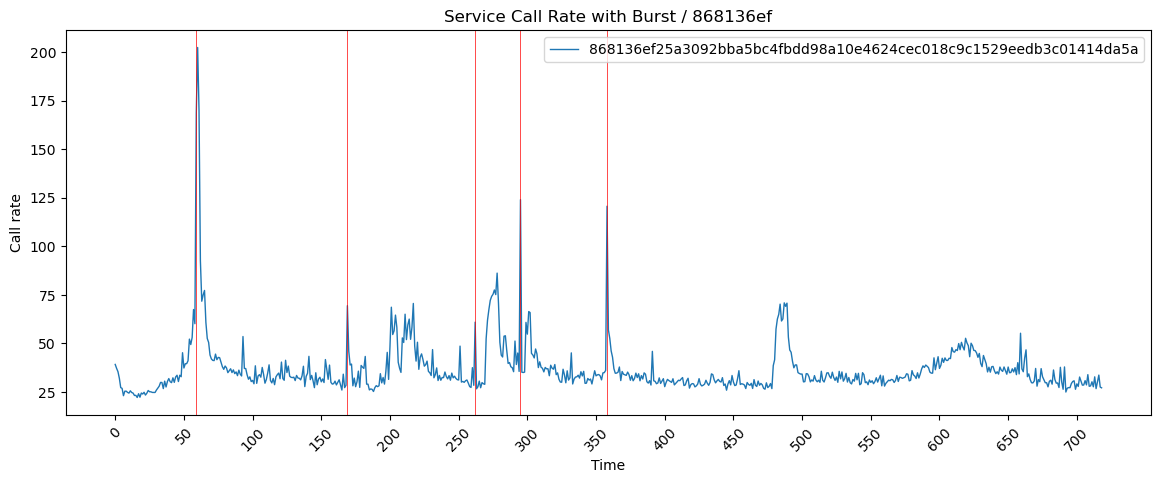

num burst: 5, ms: 90a3879b8f5f76fe4b744762acd10d5c610530f968cf2ed17477dc187e22c038


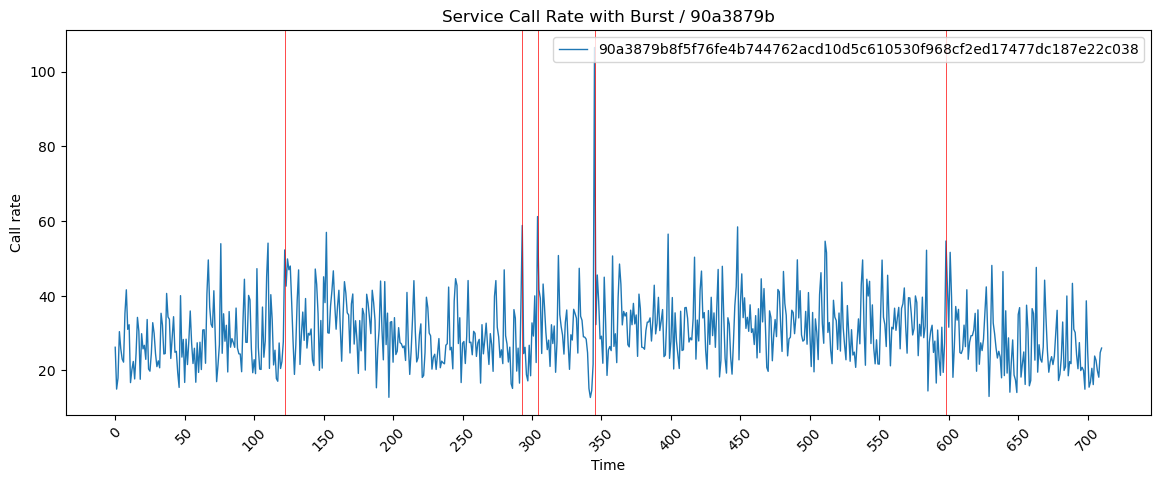

num burst: 5, ms: a86bcd9360c8bc9843b59186ba1d8ecf2dd4b5457ed8225e30ca7c47c5555bc2


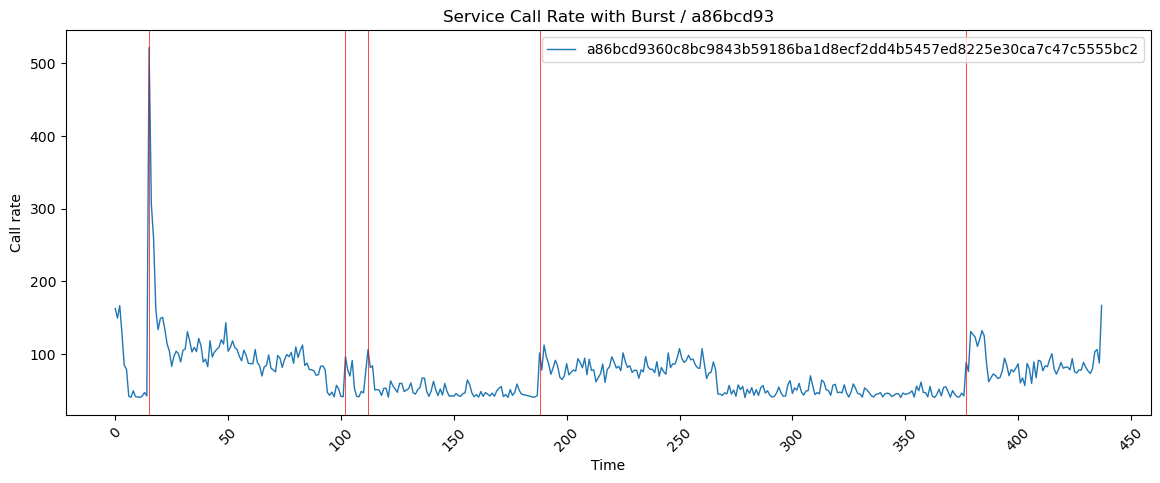

num burst: 5, ms: 5fa1ba02c172d507ef5dff9fcd998f13ed55b14cb3bd4d1658a75a2504d88cc9


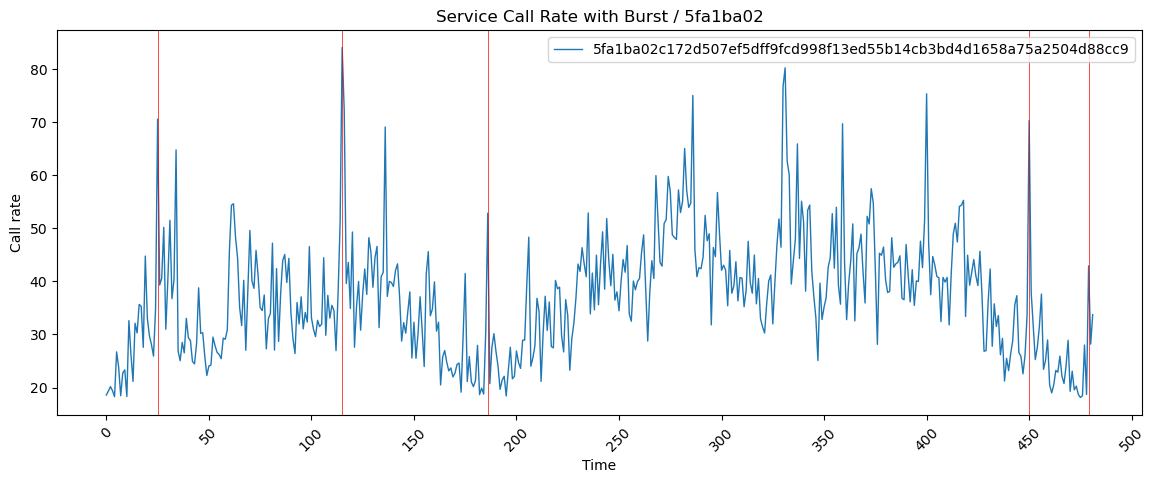

num burst: 5, ms: 3e1950674ebbb55ac780b3c0824a61909456cef828227b0d108e6f03701e3f3c


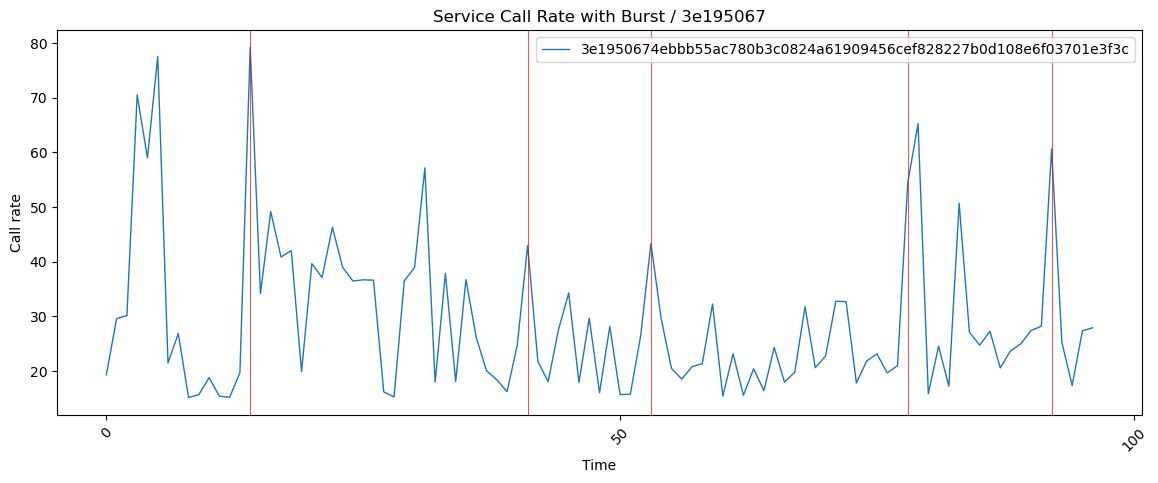

In [48]:
def plot_ms_mcr(msname, burst_cnt, call_rate, burst_ts):
    # msname = elem[0]
    # burst_cnt = elem[1]
    # call_rate_trend = elem[2]
    # burst_ts = elem[3]
    
    fname = "summedup_callrate_" + msname[:8]
    title = "Service Call Rate with Burst / " + msname[:8]
    plt.figure(figsize=(14, 5))
    plt.xticks(rotation=45)
    
    
    plt.xticks(np.arange(0, 720, 50))
    
    
    # plt.plot(mcr, linewidth=0.5, alpha=0.7)
    plt.plot(call_rate, linewidth=1, label=msname)
    for ts in burst_ts:
        plt.axvline(x = ts, linewidth=0.5, color="red")
    plt.ylabel("Call rate")
    plt.xlabel("Time")
    plt.title(title)
    plt.legend(loc="upper right")
    # plt.savefig(fname+".pdf", dpi=100, bbox_inches='tight')
    plt.show()

# for i in range(len(sort_by_burstness)):
for i in range(120, 130):
    elem = sort_by_burstness[i]
    # elem = shuffled_call_rate[i]
    ##############################
    msname = elem[0]
    burst_cnt = elem[1]
    call_rate_trend = elem[2]
    burst_ts = elem[3]
    # if burst_cnt < 10:
    if burst_cnt > 0:
        # plot_ms_mcr(msname, burst_cnt, call_rate_trend[0:10], [0])
        # plot_ms_mcr(msname, burst_cnt, call_rate_trend[:60], burst_ts[:2])
        print("num burst: {}, ms: {}".format(burst_cnt, msname))
        plot_ms_mcr(msname, burst_cnt, call_rate_trend, burst_ts)
    # else:
    #     print("{} has no burst in call trend.".format(msname))
    #     plot_ms_mcr(msname, burst_cnt, call_rate_trend, burst_ts)
    if i == 20:
        break

In [13]:
print(sort_by_burstness[3][0])
print(shuffled_call_rate[4][0])
print(len(shuffled_call_rate[4][2]))
# print(shuffled_call_rate[4][2])

8ddd4272e266357eb5f865b20d017db0588d6a2de6f5f021c62375fbe1503600
b64a200167f0ed5bd37ed6c26b72f3402f392294914ab7c0b1bf2c3d646317a6
350


In [18]:
def write_call_rate(call_rate, msname):
    temp = list()
    temp.append(msname+"\n")
    for elem in call_rate:
        temp.append(str(float(elem))+"\n")
    fname = "ms_call_rate_"+msname+".txt"
    file1 = open(fname, 'w')
    file1.writelines(temp)
    file1.close()



b64a200167f0ed5bd37ed6c26b72f3402f392294914ab7c0b1bf2c3d646317a6


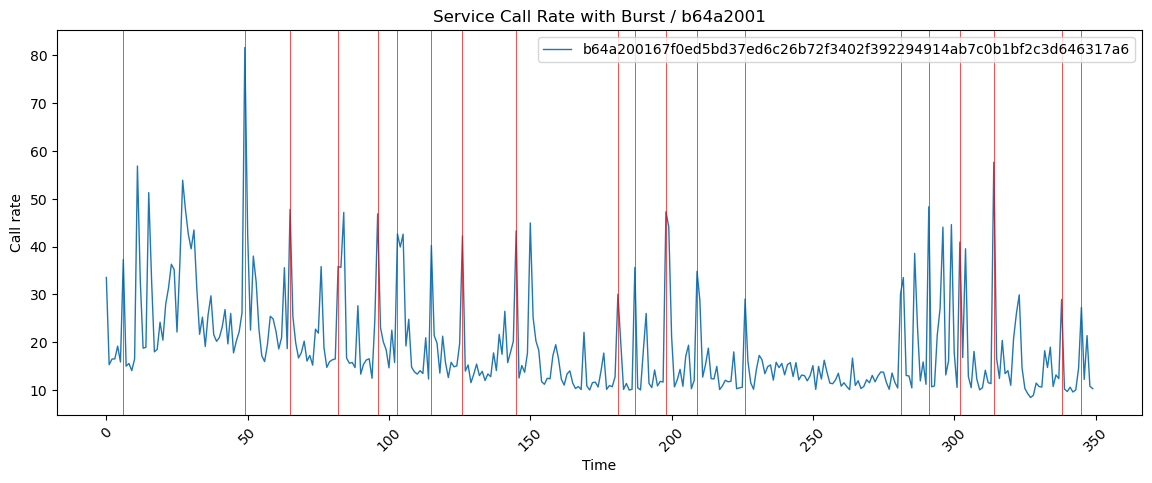

In [51]:
# key="6d9c26b935a837f3658138bf8b5c50d4798d7e491d1d0de01c23d481e399ebbc" # high 40 bursts
# key="b64a200167f0ed5bd37ed6c26b72f3402f392294914ab7c0b1bf2c3d646317a6" # medium 20 bursts
# key="75dfd0b578925aec21fbb339376281ab8f0f31b4fc4afedf68da7c20b84e4091" # low? 11 bursts
# key="782f494164510bd6d5eb4062bda9ea0f6afdc35100c16b75123bfe4c9030a730" # low 5 bursts

for  i in range(len(shuffled_call_rate)):
    if shuffled_call_rate[i][0] == key:
        key_idx = i
        break
target = shuffled_call_rate[key_idx]
print(target[0])
# write_call_rate(target[2], target[0])
msname = target[0]
burst_cnt =target[1]
call_rate_trend = target[2]
burst_ts = target[3]
plot_ms_mcr(msname, burst_cnt, call_rate_trend, burst_ts)


In [ ]:
    
# write_call_rate(sort_by_burstness[3][2], sort_by_burstness[3][0]) # 8ddd4272e266357eb5f865b20d017db0588d6a2de6f5f021c62375fbe1503600
# write_call_rate(shuffled_call_rate[4][2], shuffled_call_rate[4][0]) # b64a200167f0ed5bd37ed6c26b72f3402f392294914ab7c0b1bf2c3d646317a6